In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json
import time

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout, Flatten
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tqdm.notebook import tqdm
from functools import reduce

# If you have more than 1 GPU, you might want to specify which GPU for training.
# In this case, I have 2 GPU and the second one is RTX 2080ti, so I pick the `second` one.
os.environ['CUDA_VISIBLE_DEVICES']='1' # The second
tf.config.set_soft_device_placement(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [2]:
d_name = '20211116_wmt19_en_zh'
g_name = '20211116_translate_mle_en_zh'
folder_name = '20211118_translate_mle_en_zh_seqGAN'

encoder_wv_dim = 32
decoder_wv_dim = 32
encoder_que_pad = 65
decoder_que_pad = 207

In [3]:
if not os.path.isdir(folder_name):
    os.makedirs(folder_name)

# Load data

In [4]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/zh_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/zh_word2idx.pkl','rb'))

decoder_emb32    = pickle.load(open(f'{d_name}/en_emb32.pkl', 'rb'))
encoder_emb32    = pickle.load(open(f'{d_name}/zh_emb32.pkl', 'rb'))

In [5]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

199
4716


In [6]:
def seq2word(seq_tensor, idx2word):
    return [''.join([idx2word[i] for i in seq]) for seq in seq_tensor]

In [7]:
seq2word(decoder_vali[:1], decoder_idx2word)

['<bos>1929 or 1989?<eos>                                                                                                                                                                                                ']

In [8]:
seq2word(encoder_vali[:1], encoder_idx2word)

['1929年还是1989年?                                                    ']

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 64)


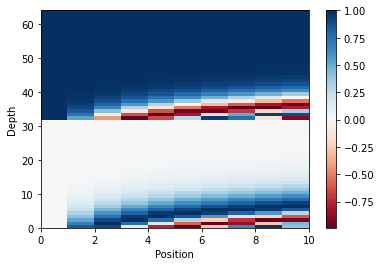

In [10]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [11]:
def band_mask(n_gram, que_pad): # For backward sequence #中間那段的mask
    mask_upper = np.tri(que_pad, que_pad, -1+n_gram)
    mask_lower = np.tri(que_pad, que_pad, -1)
    mask = mask_upper - mask_lower
    return mask

def Transformer(q_que_pad, k_que_pad, wv_dim, k_wv_dim, rate = 0.1, mask = ''):
    # Inputs
    mem  = Input((q_que_pad, wv_dim))
    encode = Input((k_que_pad, k_wv_dim))
    # Constants
    ff_dim = wv_dim*64
    # Multi-Head Attention
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(encode)
    v = Dense(wv_dim)(encode)
    # Choose a mask, default: BERT (no mask)
    mask_weights = np.ones((q_que_pad, k_que_pad))
    if mask == 'GPT':
        mask_weights = np.tri(q_que_pad, k_que_pad, 0)
    elif mask == 'band':
        mask_weights = band_mask(10, q_que_pad)
        print(mask_weights)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask_weights,
    )
    mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [mem, encode],
        [mem_new, out],
    )
    return model

def getE(wv_dim = 16):
    _input = Input((encoder_que_pad,))
    emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(encoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(encoder_emb32),
    )
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(encoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # forward sentence
    for i in range(1):
        gptLayer = Transformer(encoder_que_pad, encoder_que_pad, wv_dim, wv_dim)
        mem, output = gptLayer((mem, mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Output
    model = Model(
        _input, 
        output) 
    return model

def getD(wv_dim = 8, encoder_wv_dim = 16):
    en_output = Input((encoder_que_pad, encoder_wv_dim))
    de_input  = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    mem = emb(de_input)
    # position encoding
    pe = positional_encoding(decoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # Attention
    for j in range(1):
        # Self attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, wv_dim, mask = 'GPT')
            mem, _ = gptLayer((mem, mem))
            mem = Activation('relu')(mem)
        # Cross attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, encoder_que_pad, wv_dim, encoder_wv_dim)
            mem, output = gptLayer((mem, en_output))
            output = Activation('relu')(output)
            mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_decoder_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        [en_output, de_input], 
        output,
    )
    return model

# Language Model
def getLM():
    # Inputs
    en_input = Input((encoder_que_pad,))
    de_input = Input((decoder_que_pad,))
    # Encoder (Czech -> code)
    encoder = getE(encoder_wv_dim)
    en_output = encoder(en_input)
    # Decoder (code -> English)
    decoder = getD(decoder_wv_dim, encoder_wv_dim)
    de_output = decoder([en_output, de_input])
    # Establish the model
    model = Model(
        [en_input, de_input],
        de_output,
    )
    return model

In [12]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 65, 32)       304224      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 207)]        0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 207, 199)     319495      model_1[0][0]                    
                                                                 input_2[0][0]              

In [13]:
mleG.load_weights(f'./{g_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

768/768 [==============================] - 7s 7ms/step - loss: 0.6010 - accuracy: 0.8202
0.6009974479675293


## Inference

In [14]:
def inference(
    model,
    enData,
    inpData = None,
    start_on = 0,
    end_on = decoder_que_pad,
    batch_size = 1024,
):
    # Initialize
    num_data = len(enData)
    num_batch = (num_data-1)//batch_size +1
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    for b in range(num_batch):
        en_batch = np.zeros((batch_size, encoder_que_pad), dtype = int)
        if b == num_batch -1:
            en_batch[:num_data - (num_batch-1) * batch_size] = enData[b*batch_size:(b+1)*batch_size]
        else:
            en_batch = enData[b*batch_size:(b+1)*batch_size]
        in_batch = np.zeros((batch_size, decoder_que_pad), dtype = int)
        if start_on == 0:
            in_batch[:,0] = decoder_word2idx['<bos>']
        elif b == num_batch -1:
            in_batch[:num_data - (num_batch-1) * batch_size] = inpData[b*batch_size:(b+1)*batch_size]
        else: 
            in_batch = inpData[b*batch_size:(b+1)*batch_size]
        resp_pred = np.zeros((batch_size, decoder_que_pad), dtype = int)
        # Generate the sequence recurrsively.
        for i in range(start_on, end_on):
            # Run
            resp_pred_wv = model([en_batch, in_batch])
            the_last = resp_pred_wv[:,i]
            the_last = tf.reshape(
                tf.random.categorical(tf.math.log(the_last), 1), 
                [batch_size,]
            )
            try:
                resp_pred[:,i] = the_last
                in_batch[:,i+1] = the_last
            except:
                resp_pred[:,i] = the_last
        for i in range(len(resp_pred)):
            try:
                index = list(resp_pred[i]).index(word2idx['<bos>'])
            except:
                continue
            resp_pred[i,index+1:] = 0
            in_batch[i,index+1:] = 0
        if the_first:
            resp_pred_list = resp_pred
            in_batch_list = in_batch
            the_first = False
        else:
            resp_pred_list = np.vstack((resp_pred_list, resp_pred))
            in_batch_list = np.vstack((in_batch_list, in_batch))
    resp_pred_list = resp_pred_list[:num_data]
    in_batch_list = in_batch_list[:num_data]
    if start_on != 0:
        resp_pred_list[:,:start_on] = inpData[:,1:start_on+1]
        in_batch_list[:, :start_on+1] = inpData[:,:start_on+1]
    return resp_pred_list, in_batch_list

In [83]:
resp_pred_list, _ = inference(mleG, encoder_vali[:2])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word(teacher_vali[:2], decoder_idx2word))

# Predicted sequence
['I 1989.<eos>                                                                                                                                                                                                       ', 'PARIS – Economy, the economic and that the world renewak receiving ayond a boosting deeper is come righly uniquent we have retrictions almost likelying End hoperation us of hope.<eos>                            ']
# Real sequence
['1929 or 1989?<eos>                                                                                                                                                                                                 ', 'PARIS – As the economic crisis deepens and widens, the world has been searching for historical analogies to help us understand what has been happening.<eos>                                                       ']


In [85]:
print(encoder_vali[:2].shape)
print(decoder_vali[:2].shape)
resp_pred_list, _ = inference(mleG, encoder_vali[:2], decoder_vali[:2], start_on =5)
print(resp_pred_list)
print(teacher_vali[:2])

(2, 65)
(2, 207)
[[ 63  77 113  77   0 182 189  46 149   0  28 182 166 107   0  28  71 182
  107  31   5 198   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [ 64  68  82 173 163   0 183   0  68  46   0 182 166 107   0 102   9 158
   46 158  46   0 182  10 149 166 153   0   9  71 147 12

# Pre-Train Discriminator

##  Pre-training Data

In [ ]:
teacher_pred, decoder_pred = inference(
    mleG, 
    encoder_train[:10240], 
    batch_size = 1024,
)

teacher_pre_train_d = np.vstack([teacher_train[:10240], teacher_pred])
print(teacher_pre_train_d.shape)

reward_train = np.ones((teacher_pred.shape[0], 1)) # 1 for True
reward_pred = np.zeros((teacher_pred.shape[0], 1)) # 0 for False
reward_pre_train_d = np.vstack([reward_train, reward_pred])
print(reward_pre_train_d.shape)

In [20]:
#print(teacher_pre_train_d[-1])
#print(reward_pre_train_d[-1])

## Pre-validating Data

In [21]:
teacher_pred, decoder_pred = inference(
    mleG, 
    encoder_vali[:1024],
    batch_size = 512
)
teacher_pre_vali_d = np.vstack([teacher_vali[:1024], teacher_pred])
print(teacher_pre_vali_d.shape)

reward_vali =  np.ones((teacher_pred.shape[0], 1)) # 1 for True
reward_pred = np.zeros((teacher_pred.shape[0], 1)) # 0 for False
reward_pre_vali_d = np.vstack([reward_vali, reward_pred])
print(reward_pre_vali_d.shape)

(2048, 207)
(2048, 1)


In [22]:
#print(teacher_pre_vali_d[0])
#print(reward_pre_vali_d[0])

## Save them

In [23]:
pickle.dump(teacher_pre_train_d, open(f'{folder_name}/teacher_pre_train_d.pkl','wb'))
pickle.dump(reward_pre_train_d,  open(f'{folder_name}/reward_pre_train_d.pkl','wb'))
pickle.dump(teacher_pre_vali_d,  open(f'{folder_name}/teacher_pre_vali_d.pkl','wb'))
pickle.dump(reward_pre_vali_d,   open(f'{folder_name}/reward_pre_vali_d.pkl','wb'))

## Load them

In [18]:
teacher_pre_train_d = pickle.load(open(f'{folder_name}/teacher_pre_train_d.pkl','rb'))
reward_pre_train_d  = pickle.load(open(f'{folder_name}/reward_pre_train_d.pkl','rb'))
teacher_pre_vali_d  = pickle.load(open(f'{folder_name}/teacher_pre_vali_d.pkl','rb'))
reward_pre_vali_d   = pickle.load(open(f'{folder_name}/reward_pre_vali_d.pkl','rb'))

## Discriminator Model

In [15]:
def getC(wv_dim): # Critic/Discriminator
    resp = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim,
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    resp_emb = emb(resp)
    pe = positional_encoding(decoder_que_pad, wv_dim)
    resp_emb = LayerNormalization(epsilon=1e-6)(resp_emb+pe)
    bertLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, wv_dim)
    _, out = bertLayer((resp_emb, resp_emb))
    out, *_ = tf.split(out, decoder_que_pad, axis = 1)
    reward = Dense(1, activation = 'sigmoid')(out)
    reward = Flatten()(reward)
    model = Model(
        resp,
        reward
    )
    return model

In [16]:
mleD=getC(decoder_wv_dim)
mleD.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['binary_crossentropy'],
)
mleD.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 207)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 207, 32)      6368        input_12[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_8 (TFOpLam (None, 207, 32)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
layer_normalization_8 (LayerNor (None, 207, 32)      64          tf.__operators__.add_8[0][0]     
____________________________________________________________________________________________

In [17]:
loss_object_MleD = tf.keras.losses.BinaryCrossentropy()
optimizer_MleD = tf.keras.optimizers.Adam()

In [18]:
def loss_func_MleD(real, pred):
    loss_ = loss_object_MleD(real, pred)
    return loss_

@tf.function()
def trainMleD(te_in, y_real):
    pred = None
    loss = None
    with tf.GradientTape() as tape:
        y_pred = mleD(te_in)
        loss = loss_func_MleD(y_real, y_pred)
    gradients = tape.gradient(loss, mleD.trainable_variables)    
    optimizer_MleD.apply_gradients(zip(gradients, mleD.trainable_variables))
    return y_pred, loss

In [20]:
epoch = 300
train_d_loss = tf.keras.metrics.Mean()
batch_size = 256
num_data =  len(teacher_train)
counter = 0
d_best_loss = 999

for e in range(epoch):
    start = int(time.time())
    train_d_loss.reset_states()
    # Shuffle the data
    np.random.seed(start)
    np.random.shuffle(teacher_pre_train_d)
    np.random.seed(start)
    np.random.shuffle(reward_pre_train_d)
    # Training 
    for i in range(0, num_data, batch_size):
        teacher_batch = teacher_pre_train_d[i:i+batch_size]
        reward_batch  = reward_pre_train_d[i:i+batch_size]
        _, d_loss = trainMleD(teacher_batch, reward_batch)
        train_d_loss.update_state(d_loss)
    # NLL test
    reward_pre_vali_d_fake = mleD(teacher_pre_vali_d)
    d_vali_loss = loss_func_MleD(
        reward_pre_vali_d,
        reward_pre_vali_d_fake,
    )
    if d_vali_loss < d_best_loss:
        mleD.save(f'{folder_name}/mleD.h5')
        print('model saved.')
        d_best_loss = d_vali_loss
        counter = 0
    elif d_vali_loss > d_best_loss:
        counter += 1
    elapsed_time = time.time() - start
    print(
        f'Epoch {e+1},'
        f' D loss: {train_d_loss.result():.4f},'
        f' D NLL: {d_vali_loss:.4f},'
        f' elapsed time: {elapsed_time:.0f} secs'
    )
    # Quit condition
    if counter == 5:
        break

model saved.
Epoch 1, D loss: 0.0666, D NLL: 0.6918, elapsed time: 10 secs
Epoch 2, D loss: 0.0642, D NLL: 0.7108, elapsed time: 8 secs
Epoch 3, D loss: 0.0639, D NLL: 0.8663, elapsed time: 9 secs
Epoch 4, D loss: 0.0638, D NLL: 1.0410, elapsed time: 9 secs
Epoch 5, D loss: 0.0638, D NLL: 0.7384, elapsed time: 8 secs
model saved.
Epoch 6, D loss: 0.0627, D NLL: 0.6870, elapsed time: 8 secs
Epoch 7, D loss: 0.0614, D NLL: 0.7111, elapsed time: 9 secs
model saved.
Epoch 8, D loss: 0.0611, D NLL: 0.6769, elapsed time: 9 secs
Epoch 9, D loss: 0.0608, D NLL: 1.1400, elapsed time: 8 secs
Epoch 10, D loss: 0.0633, D NLL: 0.6789, elapsed time: 8 secs
Epoch 11, D loss: 0.0605, D NLL: 0.6913, elapsed time: 8 secs
model saved.
Epoch 12, D loss: 0.0603, D NLL: 0.6601, elapsed time: 9 secs
Epoch 13, D loss: 0.0598, D NLL: 0.6744, elapsed time: 8 secs
Epoch 14, D loss: 0.0598, D NLL: 0.6841, elapsed time: 8 secs
Epoch 15, D loss: 0.0592, D NLL: 0.6974, elapsed time: 8 secs
Epoch 16, D loss: 0.0594, 

# Load parameters onto SeqGAN models from MLE models

## Hyper params

In [19]:
lr = 1e-5

## SeqGAN generator and discriminator

### Generator

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object2 = tf.keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE # NONE for not to sum up all loss.
    #reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE,
    #reduction=tf.keras.losses.Reduction.SUM,
)

optimizer_g = tf.keras.optimizers.Adam(learning_rate = lr)

def policy_loss_function(real, pred, rewards):
    loss_ = loss_object2(real, pred)
    loss_ = loss_ * rewards[:,:,0]

    return tf.reduce_sum(loss_)

In [21]:
seqgan_g = getLM()
seqgan_g.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate = lr),
    metrics=['sparse_categorical_crossentropy'],
)
seqgan_g.trainable = True
seqgan_g.summary()

@tf.function()
def train_g_step(en_in, de_in, real, rewards):
    pred = None
    loss = None
    with tf.GradientTape() as tape:
        pred = seqgan_g((en_in, de_in))
        loss = policy_loss_function(real, pred, rewards)
    gradients = tape.gradient(loss, seqgan_g.trainable_variables)    
    optimizer_g.apply_gradients(zip(gradients, seqgan_g.trainable_variables))    
    return loss

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 65)]         0                                            
__________________________________________________________________________________________________
model_9 (Functional)            (None, 65, 32)       304224      input_15[0][0]                   
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 207)]        0                                            
__________________________________________________________________________________________________
model_12 (Functional)           (None, 207, 199)     319495      model_9[0][0]                    
                                                                 input_16[0][0]            

In [22]:
checkpoint_path_g = f"{folder_name}/seqgan_g"
ckpt_g = tf.train.Checkpoint(model=seqgan_g,optimizer=optimizer_g)
ckpt_g_manager = tf.train.CheckpointManager(ckpt_g, checkpoint_path_g, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
#if ckpt_g_manager.latest_checkpoint:
#    ckpt_g.restore(ckpt_g_manager.latest_checkpoint)
#    print ('Latest checkpoint restored!!')

### Discriminator

In [23]:
loss_d = tf.keras.losses.BinaryCrossentropy()
optimizer_d = tf.keras.optimizers.Adam(learning_rate = lr)

In [24]:
seqgan_d = getC(decoder_wv_dim)
seqgan_d.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate = lr),
    metrics=['binary_crossentropy'],
)
seqgan_d.trainable = True
seqgan_d.summary()

@tf.function()
def train_d_step(resp, rewards):
    pred = None
    loss = None
    with tf.GradientTape() as tape:
        pred = seqgan_d(resp) 
        loss = loss_d(rewards, pred)
    gradients = tape.gradient(loss, seqgan_d.trainable_variables)    
    optimizer_d.apply_gradients(zip(gradients, seqgan_d.trainable_variables))
    return pred, loss

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 207)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 207, 32)      6368        input_26[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.add_19 (TFOpLa (None, 207, 32)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
layer_normalization_19 (LayerNo (None, 207, 32)      64          tf.__operators__.add_19[0][0]    
___________________________________________________________________________________________

In [25]:
checkpoint_path_d = f"{folder_name}/seqgan_d"
ckpt_d = tf.train.Checkpoint(model=seqgan_d,optimizer=optimizer_d)
ckpt_d_manager = tf.train.CheckpointManager(ckpt_d, checkpoint_path_d, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
#if ckpt_d_manager.latest_checkpoint:
#    ckpt_d.restore(ckpt_d_manager.latest_checkpoint)
#    print ('Latest checkpoint restored!!')

# Reward for Every Generation Step (REGS).

In [26]:
def model_g_predict_batch(model, _inp_list, batch_size, num_data, step, **kwargs):
    is_first = 1
    y_out = None
    num_batch = num_data // batch_size +1
    for i in range(0, num_batch*batch_size , batch_size):
        y = model([_inp[i:i+batch_size] for _inp in _inp_list], **kwargs)[:,step]
        if is_first:
            is_first = 0
            y_out = y
        else:
            y_out = np.vstack([y_out, y])
    return y_out

def model_predict_batch(model, _inp_list, batch_size, num_data, **kwargs):
    y_out = tf.stack(
        [ model([_inp[i:i+batch_size] for _inp in _inp_list], **kwargs) 
         for i in range(0, num_data, batch_size)]
    )
    return y_out

# Under revision, not finished yet
def regs_mcmc(
    model_g, 
    model_d,
    en_in, 
    y_inp = None, 
    start_on = 0, 
    end_on = 10, 
    beam = 2,
):
    # If start on the end of sequence, return.
    if start_on == decoder_que_pad -1:
        return model_d.predict(y_inp)
    # Initialize
    num_data = y_inp.shape[0]
    en_mcmc = np.array(en_in[:], dtype = int)
    y_mcmc = np.zeros((num_data, decoder_que_pad), dtype = int)
    de_mcmc = np.zeros((num_data, decoder_que_pad), dtype = int)
    r_out = None
    de_mcmc[:,0] = decoder_word2idx['<bos>']
    if not isinstance(y_inp, type(None)):
        y_mcmc[:, :start_on+1] = y_inp[:, :start_on+1]
        de_mcmc[:, 1:start_on+2] = y_inp[:, :start_on+1]

    # It determines which word to pass down.
    beam_list = np.ones(decoder_que_pad, dtype = int)*beam
    beam_list[:start_on+1] = 1
    beam_list[start_on] = num_data
    # bcList stands for beam-candidate list
    bcList = []
    for i in range(decoder_que_pad):
        if i < start_on+1:
            bcList.append([])
        elif i >= start_on+1:
            bcList.append(list(range(num_decoder_words-beam_list[i], num_decoder_words)))
        else:
            print('Warning')
    #print(bcList)
    # Generate sequences using MCMC
    for t in range(start_on+1, end_on+1):
        to_expand = beam_list[t]
        the_last = model_g_predict_batch(
            model_g, 
            [en_mcmc, de_mcmc], 
            batch_size = 2048, 
            num_data = len(de_mcmc), 
            step = t,
        )
        most_possible = np.argsort(the_last, axis = 1)
        most_possible = np.transpose(
            most_possible[:,bcList[t]]).reshape(
            reduce(lambda x,y: x*y, beam_list[:t+1])
        )
        en_mcmc = np.tile(en_mcmc, (to_expand, 1))
        de_mcmc = np.tile(de_mcmc, (to_expand, 1))
        y_mcmc = np.tile(y_mcmc, (to_expand, 1))
        y_mcmc[:,t] = most_possible
        #print(en_mcmc.shape)
        #print(de_mcmc.shape)
        #print(y_mcmc.shape)
        #print('---')
        if t+1 < decoder_que_pad:
            de_mcmc[:,t+1] = most_possible
    # Rank all synthetic sequences
    r_mcmc = model_d.predict(y_mcmc)
    r_out = np.reshape(np.array([
        tf.reduce_mean(r_mcmc[np.arange(i, len(r_mcmc), num_data)], axis = 0) for i in range(num_data)
    ]), (num_data, 1))
    # Rank each tokens
    return r_out

In [44]:
#print(decoder_train[:4])
#print(teacher_train[:4])
r_tmp = regs_mcmc(
    seqgan_g, 
    seqgan_d, 
    encoder_train[:4],
    teacher_train[:4], 
    start_on = 2,
    end_on = 11,
    beam = 2,
)
print(r_tmp)

[[0.57967085]
 [0.58143747]
 [0.44573095]
 [0.2980736 ]]


## REGS main function

In [27]:
# Regs for one context
def regs(model_g, model_d, enData, beam = 2):
    r_out = np.zeros((enData.shape[0], decoder_que_pad, 1))
    y_out, de_in = inference(model_g, enData)
    y_out = np.array(y_out, dtype = np.int32)
    de_in = np.array(de_in, dtype = np.int32)
    for q in range(0, decoder_que_pad):
        # The roll-out length is 10
        q10 = q + 10 - 1
        if q+10 >= decoder_que_pad:
            q10 = decoder_que_pad -1
        r_tmp = regs_mcmc(
            model_g,
            model_d,
            enData,
            y_out,
            start_on = q, # Fix first q words and see the reward.
            end_on = q10,
            beam = beam,
        )
        r_out[:, q] = r_tmp[:]
    # Variance reducing
    r_mean = np.mean(r_out, axis = 0)
    r_out = r_out - r_mean
    r_out = np.array(r_out, dtype = np.float32)
    return de_in, y_out, r_out

In [46]:
st = float(time.time())
de_in, y_out, r_out = regs(
    seqgan_g, 
    seqgan_d, 
    enData = encoder_train[:4],
)
print(de_in.dtype)
print(y_out.dtype)
print(r_out)
print(r_out.dtype)
print(r_out.shape)
print('It takes {0:.3f} sec.'.format(float(time.time()) - st))

int32
int32
[[[-0.0280029 ]
  [-0.02804524]
  [-0.02808037]
  [-0.02797407]
  [-0.02798048]
  [-0.02794223]
  [-0.02799205]
  [-0.02805932]
  [-0.02804729]
  [-0.0280321 ]
  [-0.0279795 ]
  [-0.02790358]
  [-0.02793542]
  [-0.02787806]
  [-0.02792408]
  [-0.02788629]
  [-0.02786341]
  [-0.02785605]
  [-0.0279609 ]
  [-0.02795756]
  [-0.0279142 ]
  [-0.02791004]
  [-0.02794739]
  [-0.02793569]
  [-0.02793002]
  [-0.0279094 ]
  [-0.02791344]
  [-0.02795114]
  [-0.02800065]
  [-0.02797145]
  [-0.0279642 ]
  [-0.02790622]
  [-0.02789776]
  [-0.02787557]
  [-0.02785873]
  [-0.02785786]
  [-0.02782436]
  [-0.02779176]
  [-0.02778708]
  [-0.02777966]
  [-0.02776162]
  [-0.0277656 ]
  [-0.02776456]
  [-0.0277648 ]
  [-0.02776543]
  [-0.02776385]
  [-0.02777765]
  [-0.02779461]
  [-0.02777971]
  [-0.02775141]
  [-0.02776356]
  [-0.02775406]
  [-0.0276907 ]
  [-0.02766434]
  [-0.02762859]
  [-0.02761371]
  [-0.0276138 ]
  [-0.0276071 ]
  [-0.02759771]
  [-0.0275829 ]
  [-0.02759264]
  [-0.027581

In [28]:
mleG.load_weights(f'./{g_name}/mleG.h5')
mleD.load_weights(f'./{folder_name}/mleD.h5')

In [29]:
seqgan_g.load_weights(f'./{g_name}/mleG.h5')
seqgan_d.load_weights(f'./{folder_name}/mleD.h5')

In [30]:
loss, _acc = mleG.evaluate([encoder_vali, decoder_vali], teacher_vali)
print(loss)
loss, _acc = seqgan_g.evaluate([encoder_vali, decoder_vali], teacher_vali) # Full-test-data NLL test
print(loss)

768/768 [==============================] - 5s 7ms/step - loss: 0.6010 - accuracy: 0.8202
0.6009974479675293
768/768 [==============================] - 6s 7ms/step - loss: 0.6010 - sparse_categorical_crossentropy: 0.6010
0.6009975075721741


# Training process

In [31]:
batch_size = 64
minibatch_size = 32
epoch = 300
g_best_loss = 999
num_batch = int(len(teacher_train)//batch_size)
report_iter = 5
g_iter = 5

In [32]:
train_g_loss = tf.keras.metrics.Mean()
train_d_loss = tf.keras.metrics.Mean()

sec = int(time.time())

g_nll_list = []
counter = 0
p_time = time.time() # Estimate the time for 50 batches.
for e in range(epoch):
    start = time.time()
    
    train_g_loss.reset_states()
    train_d_loss.reset_states()
    
    np.random.seed(sec)
    np.random.shuffle(encoder_train)
    np.random.seed(sec)
    np.random.shuffle(decoder_train)
    np.random.seed(sec)
    np.random.shuffle(teacher_train)
    #np.random.seed(sec)
    #np.random.shuffle(encoder_vali)
    #np.random.seed(sec)
    #np.random.shuffle(decoder_vali)
    #np.random.seed(sec)
    #np.random.shuffle(teacher_vali)
    for i in range(num_batch):
        print(f'Batch {counter+1}')
        #----------------------------- 
        # Evaluate the loss on model G every 50 batches
        if counter % report_iter == 0:
            syn_vali = [] # syn for Synthesized Data
            for j in range(0, 1024, 128): # Define Test data size
                t = seqgan_g.predict(
                    [encoder_vali[j:j+128], decoder_vali[j:j+128]], 
                    batch_size = 128
                )
                syn_vali.append(t)
            syn_vali = np.vstack(syn_vali)
            g_vali_loss = loss_object(teacher_vali[:1024], syn_vali)
            # Evaluate the loss on model D
            syn_vali = np.argmax(syn_vali, axis = -1)
            r_vali_fake = seqgan_d(np.vstack([teacher_vali[:1024], syn_vali]))
            d_vali_loss = loss_d(
                np.vstack([
                    np.ones((1024, 1)), 
                    np.zeros((1024, 1))]),
                r_vali_fake,
            )
            g_nll_list.append(g_vali_loss)
            # Save the model G if it is better
            if g_vali_loss < g_best_loss:
                g_best_loss = g_vali_loss
                ckpt_save_path = ckpt_g_manager.save()
                ckpt_save_path = ckpt_d_manager.save()
                print('model saved.')
        #----------------------------- 
        # Data preparation
        # Real part
        e_real_batch = encoder_train[i*batch_size:(i+1)*batch_size]
        x_real_batch = decoder_train[i*batch_size:(i+1)*batch_size]
        y_real_batch = teacher_train[i*batch_size:(i+1)*batch_size]
        r_real_batch  = np.ones((batch_size, 1))
        # Synthesized part
        y_fake_batch, x_fake_batch = inference(
            seqgan_g, 
            e_real_batch,
        )
        r_fake_batch = np.zeros((batch_size, 1))
        # Real + fake and then training
        x_batch = np.vstack((x_real_batch, x_fake_batch))
        y_batch = np.vstack((y_real_batch, y_fake_batch))
        r_batch = np.vstack((r_real_batch, r_fake_batch))
        #----------------------------- 
        # Train D with minibatch approaches.
        for j in range(0, batch_size, minibatch_size):
            y_minibatch = y_batch[j:j+minibatch_size]
            r_minibatch = r_batch[j:j+minibatch_size]
            _, d_loss = train_d_step(
                y_minibatch, 
                r_minibatch,
            )
            train_d_loss.update_state(d_loss)
        #----------------------------- 
        # Update Generator after certain batches
        if counter % g_iter == 0:
            gST = time.time()
            de_in_mcmc, y_out_mcmc, r_out_mcmc = regs(
                seqgan_g, 
                seqgan_d, 
                enData = e_real_batch,
                beam = 2,
            )
            # Train G
            gstep = minibatch_size
            for k in range(0, len(de_in_mcmc), gstep):
                # Update model
                g_loss = train_g_step(
                    e_real_batch[k:k+gstep],
                    de_in_mcmc[k:k+gstep],
                    y_out_mcmc[k:k+gstep],
                    r_out_mcmc[k:k+gstep],
                )
            train_g_loss.update_state(g_loss)
            # Teacher forcing
            g_loss = seqgan_g.train_on_batch([e_real_batch, x_real_batch], y_real_batch)
            train_g_loss.update_state(g_loss)
        #-----------------------------
        # 50 batches in time
        if counter % report_iter == 0:
            elapsed_time = time.time() - p_time
            p_time = time.time()
            print(
                f'Batch: {counter+1}, '
                f'AdvG loss: {train_g_loss.result():.4f}, '
                f'D loss: {train_d_loss.result():.4f}, '
                f'G NLL: {g_vali_loss:.4f}, '
                f'D NLL: {d_vali_loss:.4f}, '
                f'elapsed time: {elapsed_time:.0f} secs'
            )
        counter += 1

Batch 1
model saved.
Batch: 1, AdvG loss: -24.1018, D loss: 0.6820, G NLL: 0.6139, D NLL: 0.6017, elapsed time: 1435 secs
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
model saved.
Batch: 6, AdvG loss: -6.7229, D loss: 0.6438, G NLL: 0.6136, D NLL: 0.6034, elapsed time: 1540 secs
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
model saved.
Batch: 11, AdvG loss: -6.7147, D loss: 0.6517, G NLL: 0.6133, D NLL: 0.6060, elapsed time: 1540 secs
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
model saved.
Batch: 16, AdvG loss: -9.5157, D loss: 0.6447, G NLL: 0.6131, D NLL: 0.6089, elapsed time: 1535 secs
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
model saved.
Batch: 21, AdvG loss: -13.3246, D loss: 0.6359, G NLL: 0.6130, D NLL: 0.6121, elapsed time: 1530 secs
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
model saved.
Batch: 26, AdvG loss: -15.5996, D loss: 0.6322, G NLL: 0.6129, D NLL: 0.6163, elapsed time: 1529 secs
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
model saved.
Batch: 31, AdvG loss: -15.8506, 

KeyboardInterrupt: 

In [ ]:
print(e_real_batch.shape)
print(de_in_mcmc.shape)
print(y_out_mcmc.shape)
print(r_out_mcmc.shape)

In [250]:
pred = seqgan_g((encoder_vali[:4], decoder_vali[:4]))
print(pred.shape)

reward = np.ones((pred.shape[0], pred.shape[1], 1))
print(reward.shape)

loss = loss_object2(teacher_vali[:4], pred)
print(loss.shape)

loss = policy_loss_function(teacher_vali[:4], pred, reward)

(4, 207, 199)
(4, 207, 1)
(4, 207)
tf.Tensor(4657.9746, shape=(), dtype=float32)
